In [1]:
!pip install "gluonts[torch]" orjson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 21.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatibl

In [1]:
import gluonts, orjson
from gluonts.torch import DeepAREstimator, TemporalFusionTransformerEstimator
#PyTorchLightningEstimator, PyTorchPredictor, DeepNPTSEstimator, SimpleFeedForwardEstimator, WaveNetEstimator, DLinearEstimator, PatchTSTEstimator, LagTSTEstimator
import numpy as np
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
import matplotlib.pyplot as plt

In [2]:
def new_ds(df: pd.DataFrame, freq: str='D') -> gluonts.dataset.Dataset:
  '''Конвертирует pandas dataframe в датасет.
  Входной параметр: df - датафрейм следующего формата: индекс - дата,
    target  - обязательная колонка, содержащая целевое значение.
  Возвращает датасет в виде Dataset.'''
  return PandasDataset(df, target='target', freq=freq)

def new_model(ds: gluonts.dataset.Dataset, pred_len: int, estimator: int=0,
              epochs: int=20, freq: str='D') -> gluonts.model.Predictor:
  '''Получает обученную модель на датасете.
  Входные параметры:
    ds - датасет для обучения,
    pred_len - длина прогноза,
    estimator - тип оценки (0 - DeepAREstimator,
      1 - TemporalFusionTransformerEstimator)
    epochs - количество проходов,
    lr - скорость обучения,
    freq - таймфрейм.
  Возвращает объект.'''
  if estimator == 0:
    estim = DeepAREstimator(prediction_length=pred_len, freq=freq,
                            trainer_kwargs={"max_epochs": epochs})
  elif estimator == 1:
    estim = TemporalFusionTransformerEstimator(prediction_length=pred_len, freq=freq,
                                               trainer_kwargs={"max_epochs": epochs})
  return estim.train(ds)

In [3]:
# Загружаем данные
df = pd.read_csv('/content/drive/MyDrive/trainee/Ingate/Ozon/data_ozon.csv',
                 parse_dates=['День'])
# Переименовываем длинные названия с пробелами и кириллическими буквами
dic_ren = {'День': 'timestamp', 'Показы, всего': 'target'}
           #'Показы в поиске и каталоге': 'dyn_real_3'}
df = df.rename(columns=dic_ren)
freq = 'D'
# Отбираем только нужные столбцы
df = df[['timestamp', 'target']]
          #'dyn_real_1', 'dyn_real_2', 'dyn_real_3']]
# Отбираем товары с большим количеством заказов
df = df.groupby('timestamp').target.sum()
# Сортируем по индексу
df.sort_index(inplace=True)
# Делим на обучающую и проверочные выборки
df_train = df.loc[:'2023-05-01']
df_val = df.loc['2023-05-01':]
# Горизонт прогноза будет равен длине проверочной выборки
pred_len = df_val.index.nunique()
ds_train = new_ds(df_train)
# Обучение
model = new_model(ds_train, pred_len, 1)

<ipython-input-3-f66e13f80d01>:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/trainee/Ingate/Ozon/data_ozon.csv',
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                           | Params | In sizes | Out sizes 
---------------------------------------------------------------------------------
0 | model | TemporalFusionTransformerModel | 

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 107924.10156 (best 107924.10156), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 96373.88281 (best 96373.88281), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached 82217.42969 (best 82217.42969), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached 69962.09375 (best 69962.09375), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached 63914.33594 (best 63914.33594), saving mod

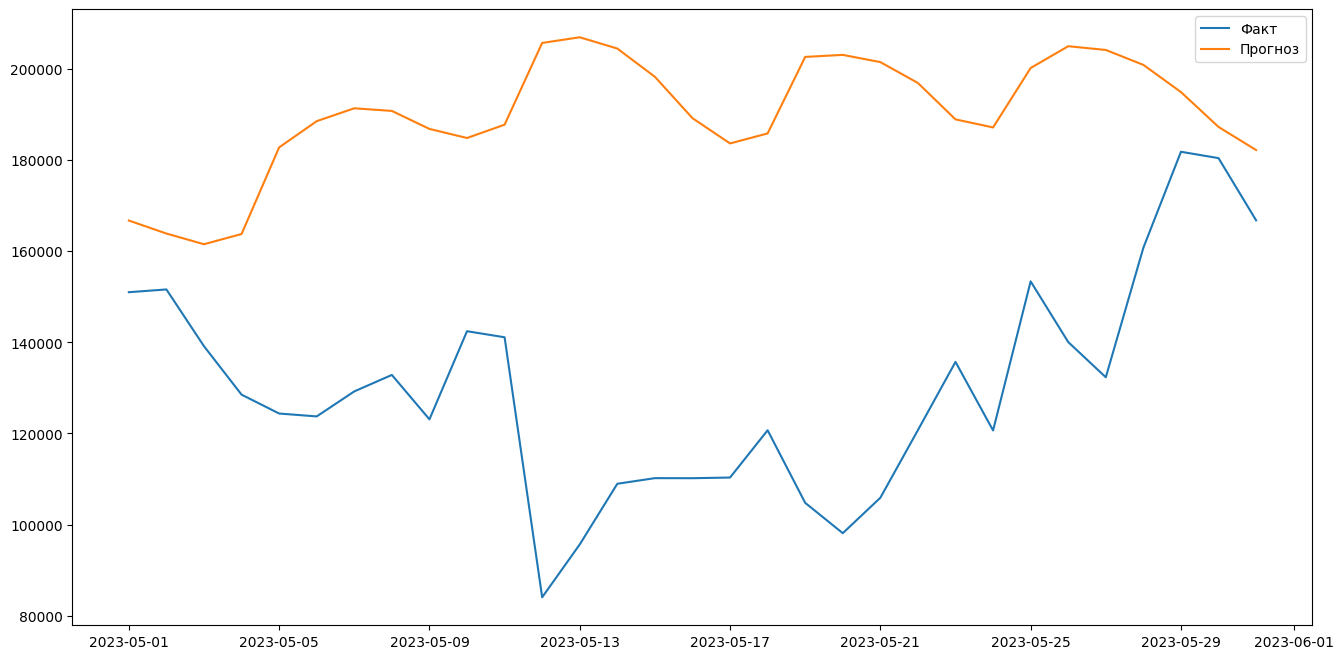

In [ ]:
# График
ds_val = new_ds(df_val)
pred = list(model.predict(ds_val))[0]
y_pred = pred.median
y_true = df_val.to_numpy(float)
x = df_val.index.to_numpy()
plt.figure(figsize=(16, 8))
plt.plot(x, y_true, label='Факт')
plt.plot(x, y_pred, label='Прогноз')
plt.legend()
plt.show()